# TN Ex 02: Predictive Coding & the Hierarchical Gaussian Filter
Spring Semester 2025

**Exercise submission deadline** (via Moodle): Tuesday 6pm, March 25, 2025.

Exercise discussion: Friday 2pm, March 28, 2025.

Please enter your exercise group (number + names of all group members): 


- Exercise group 1

- members: Lena Fiedor, Valentin Magis, Victoria Ploerer


## References

**Julia**
- The [Julia Programming Language](https://julialang.org/)
- A useful reference to help you set up your Julia environment and run an interactive notebook: https://julia.quantecon.org/getting_started_julia/getting_started.html
- Julia [Cheat Sheet](https://cheatsheet.juliadocs.org/)

**Predictive Coding**
- Bogacz et al. (2017): https://doi.org/10.1016/j.jmp.2015.11.003

**Hierarchical Gaussian Filtering**
- Mathys et al. (2011) https://doi.org/10.3389/fnhum.2011.00039 & Mathys et al. (2014) https://doi.org/10.3389/fnhum.2014.00825
- The 'generalized HGF' (Weber et al. 2023): https://doi.org/10.48550/arXiv.2305.10937
- [HierarchicalGaussianFiltering.jl package](https://github.com/ComputationalPsychiatry/HierarchicalGaussianFiltering.jl) incl [docs](https://computationalpsychiatry.github.io/HierarchicalGaussianFiltering.jl/dev/)
- [ActionModels.jl package](https://github.com/ComputationalPsychiatry/ActionModels.jl) incl [docs](https://computationalpsychiatry.github.io/ActionModels.jl/dev/)


## Setup

The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.11.3
Commit d63adeda50 (2025-01-21 19:42 UTC)
Build Info:
  Built by Homebrew (v1.11.3)

    Note: This is an unofficial build, please report bugs to the project
    responsible for this build and not to the Julia project unless you can
    reproduce the issue using official builds available at https://julialang.org/downloads

Platform Info:
  OS: macOS (arm64-apple-darwin24.2.0)
  CPU: 12 × Apple M3 Pro
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, apple-m2)
Threads: 1 default, 0 interactive, 1 GC (on 6 virtual cores)
Environment:
  JULIA_NUM_THREADS = 


Now we need to activate our project environment and load a few julia packages which are specified in the Project.toml file.

In [2]:
# running this for the first time takes a couple of mins...
using Pkg
Pkg.activate(joinpath(@__DIR__, "Project.toml"))
Pkg.instantiate()

  Activating project at `~/INI/Translational Neuromodeling/Translational_Neuromodeling_Exercise_1/ex-02`


In [3]:
# load packages
using Random
using Plots
using LaTeXStrings
using Optim

using Printf
using Statistics
using LinearAlgebra

# HGF
using HierarchicalGaussianFiltering
using ActionModels
using StatsPlots
using Distributions
using CSV
using DataFrames
using LogExpFunctions
using Turing

In [4]:
pkgs = Pkg.installed()
print(pkgs["HierarchicalGaussianFiltering"], "\n")
print(pkgs["ActionModels"])

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /opt/homebrew/Cellar/julia/1.11.3/share/julia/stdlib/v1.11/Pkg/src/Pkg.jl:787


0.6.2
0.6.6

For reproducibility purposes, we fix the seed of the random number generator.

In [5]:
# fix rng seed
rng = MersenneTwister(1234)

MersenneTwister(1234)

&nbsp;
___
___
&nbsp;

## Exercise 2.1: Speed of convergence in Predictive Coding

In this exercise, we will have a closer look on the convergence behaviour of predictive coding algorithms. We use the same model as [Bogacz (2017)](https://doi.org/10.1016/j.jmp.2015.11.003), so we have 
\begin{align}
p(x) &=  \frac{1}{\sqrt{2\pi\Sigma_{pr}}} \exp^{-\frac{(x-\mu_{pr})^2}{2\Sigma_{pr}}} \\
p(y|x) &= \frac{1}{\sqrt{2\pi\Sigma_{gen}}} \exp^{-\frac{(y - g(x))^2}{2\Sigma_{gen}}}
\end{align}  
for prior $p(x)$ and likelihood $p(y|x)$, where $g(x)=x^2$.
To enable concrete calculations, we set $\Sigma_{pr} = 1$, $\Sigma_{gen} = 1$, $\mu_{pr} = 3$. In addition, we assume that we observe $y = 2$.

We want to approximate our posterior $p(x|y)$ by a delta-distribution $q_\phi(x) = \delta(x - \phi)$. We could do that for every $\phi$, but we want to find the value $\phi_0$, s.t. the delta-distribution is nonzero at the maximum of the posterior. One can show (see Bogacz, 2017), that this is equivalent to finding the argmax of 
\begin{align}
F(x) = \ln(p(y|x)) + \ln(p(x)).
\end{align} 
Note that $F$ is only equal to the log-joint for this particular choice of $q_\phi(x)$. If we would approximate the posterior by a different function class, $F$ would have a different form

a) Plot posterior $p(x|y)$ and $F(x)$ for $x \in [0,4]$. Is the posterior normal?  *(3 points)*

In [6]:
# insert your solution here ...

&nbsp;
___

Our $F(x)$ is rather a $F(\phi)$. Because of our particular approximation, $x$ and the parameter $\phi$ *live* on the same scale, but for the rest of the exercise we will talk about $F(\phi)$ to remind us that we are looking for $\phi_0$, the parameter giving us the *best* approximation $q_{\phi_0}(x)$ of the posterior $p(x|y)$.

b) Determine $\phi_0$ (up to a small error) by performing a direct gradient ascent $\phi(\tau + \Delta\tau) = \phi(\tau) + \Delta \tau \cdot \frac{\text{d} F}{\text{d} \phi}$ on $F(\phi)$. Start at $\mu_{pr}$ and plot $\phi(\tau)$ against $\tau$ for some reasonable time interval.  *(3 points)*

*Hint: You can use a step size of $\Delta\tau = 0.01$.*

In [7]:
# insert your solution here ...

&nbsp;
___

The (direct) gradient ascent allowed us to find $\phi_0$, but one can argue, that the difference/differential equation, we integrate in (b) might be too complex to be implemented neurally.

To simplify the equation, we introduce the *prediction-error*-quantities $\tilde \epsilon_{gen}$ and $\tilde \epsilon_{pr}$. To compute them, we need two additional differential equations, so that we have now three (coupled) differential equations (but with an easier structure):
\begin{align}
		\dot\phi &= \epsilon_{gen} \cdot g'(\phi) + \epsilon_{pr} \\
        \dot \epsilon_{gen} &= y - g(\phi)  - \Sigma_{gen}\cdot \epsilon_{gen} \\
        \dot \epsilon_{pr} &= \mu_{pr} - \phi - \Sigma_{pr} \cdot \epsilon_{pr}
\end{align}

c) Determine $\phi_0$ (up to a small error) by discretizing and then integrating equations the three differential equations above. Use the same step size as for (b) and plot the evolution of $\phi$, $\epsilon_{pr}$ and $\epsilon_{gen}$ against $\tau$.  *(4 points)*


In [8]:
# insert your solution here ...

&nbsp;
___

d) Which of the two methods used in (b) and (c) converges faster? Why?  *(2 points)*

In [9]:
# insert your solution here ...

&nbsp;
___
___
&nbsp;

## 2.2 The HGF Julia Implementation and Experimental Design

This exercise is intended to get you started with the HGF Julia implementation and understand the relation between the generative model and the update equations (resulting from variational inversion of the generative model) better.

a) Briefly summarise the content and use of the two Julia packages [HierarchicalGaussianFiltering.jl](https://github.com/ComputationalPsychiatry/HierarchicalGaussianFiltering.jl) and [ActionModels.jl](https://github.com/ComputationalPsychiatry/ActionModels.jl). How are the two packages related to each other? *(2 points)*



**ActionModels.jl**: Provides a framework for defining and customizing behavioral models, allowing for adaptable computational modeling of behavior and cognition.

**HierarchicalGaussianFiltering.jl**: Implements the generalized Hierarchical Gaussian Filter (HGF), a Bayesian model for tracking beliefs and their uncertainties across multiple hierarchical levels. It’s useful for modeling cognitive and behavioral data where underlying states and their volatilities evolve over time. It uses the ActionModels framework and provides a custom model for how states are updated.

&nbsp;
___

In the lecture, we looked at the three level HGF for binary outcomes with perceptual parameters $\kappa$, $\omega$, and $\vartheta$. However, in the software implementation, the parameters $\kappa$ and $\omega$ exist on all levels. On the first level, $\kappa_1$ can be set to 1 to obtain the original model, and $\omega_1$ is undefined. On the highest level, $\kappa_n$ is undefined, and $\omega_n$ corresponds to our previous $\vartheta$. In symmetry to lower levels however, $\omega_3$ describes the log-variance of the Gaussian. Therefore:
\begin{equation}
  \vartheta = \exp(\omega_3)
\end{equation}
in the binary HGF with 3 levels. In this exercise, we will always provide both values to avoid confusion.

b) The Julia packages allow us to simulate beliefs (mean $\mu$, precision $\pi$) and behavior $y$ in response to sensory inputs $u$, using the perceptual model of the HGF (and an appropriate action model). But first, we take a step back and generate sensory inputs $u$ using the HGF. Write a function that implements the generative model for the three level HGF for binary outcomes and generates binary events $u$ according to it. *Hint: These equations were given in the lecture and are not implemented in the software package.*

To start, choose the following parameter setting:
\begin{equation}
  \kappa_2 = 1, \quad \omega_2 = -4, \quad \vartheta = \exp(\omega_3) = \exp(-6)
\end{equation}
You can use the following values for the initial states:
\begin{equation}
    x_2^{(0)}=0, \quad  x_3^{(0)}=1
\end{equation}
Plot the resulting traces of $x_3$, $x_2$, and the generated inputs $u$ for a given number of trials (suggestion: plot the trajectories for a trial number of 320). Repeat this procedure a few times and examine the typical traces you get. Also try out different parameter settings, in particular, higher values for $\vartheta$. What do you observe? *(4 points)*

In [10]:
# insert your solution here ...

&nbsp;
___

c) Decide on one input sequence that you generated, simulate beliefs and responses using the 3-level HGF for binary inputs (perceptual model) in combination with the unit-square sigmoid action model with the same (or other) parameters that you used during input generation. Does your simulated agent correctly track the evolution of $x_3$ and $x_2$? *(3 points)*

*Hint: You can use the premade hgf `binary_3level` in combination with the premade agent `hgf_unit_square_sigmoid`.*

The following table summarises the naming conventions for parameters and states used in the HierarchicalGaussianFiltering.jl package (the greek letters correspond to the naming used in the lecture slides and in Mathys et al. [2011](https://doi.org/10.3389/fnhum.2011.00039), [2014](https://doi.org/10.3389/fnhum.2014.00825)):

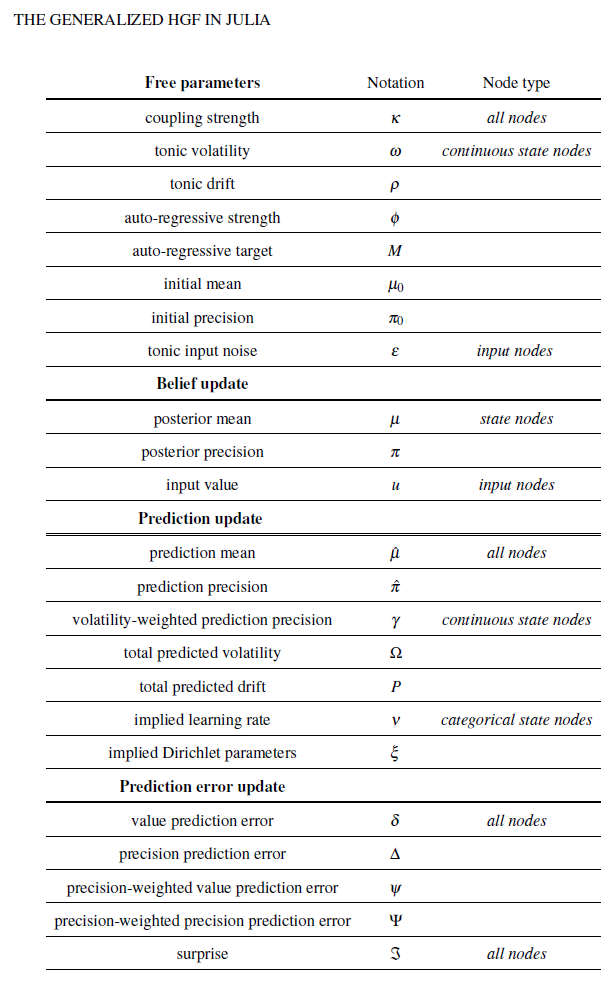

e.g., in the premade binary_3level HGF, the parameter $\kappa_2$ representing the coupling strength between the probability $x_2$ and volatility $x_3$ is referred to as ```("xprob", "xvol", "coupling_strength")``` in the code. Analogously for $\omega_2$ and ```("xprob", "volatility")```, $\mu_2^{(0)}$ and ```("xprob", "initial mean")```, ...


In [11]:
# insert your solution here ...

&nbsp;
___

d) Why, do you think, would it be a good or bad idea to use the generative model of the HGF to generate stimulus sequences to use in an experiment? If you think it's a bad idea, why could it still be a useful model for the agent to invert during perception? *(2 points)*

In [12]:
# insert your solution here ...

&nbsp;
___
___
&nbsp;

## 2.3 Coordinate Choice and Parameter Identifiability in the HGF

In this exercise, you will learn how you can build your own HGF and action models using the respective julia packages. Moreover, we take a closer look at the meaning of the perceptual parameters of the three level HGF for binary outcomes and their relationships. The observations we will make, however, generalize to any HGF with $n$ levels and both categorical as well as continuous outcomes. 

For this exercise, make use of the example binary input sequence that is contained in the `classic_binary_inputs.csv` file within the zip-folder of ex02.

In [36]:
u3 = CSV.read(joinpath(@__DIR__, "classic_binary_inputs.csv"), DataFrame)[!, 1];

a) Simulate beliefs and responses using the 3-level HGF for binary inputs (perceptual model). with the following parameters:

\begin{equation}
  \begin{split}
  \mu_3^{(0)} = 1&, \quad \sigma_3^{(0)} = 1, \\
  \kappa_2 = 2.5&, \quad \omega_2 = -4, \\
  \vartheta = \exp(\omega_3) &= \exp(-6) = 0.0025,
  \end{split}
\end{equation}

in combination with the unit-square sigmoid action model with parameter: 

$$ \zeta = 5. $$

For this exercise, do **NOT** use the premade agent `binary_3level` but rather build the 3-level HGF for binary inputs on your own using the `init_hgf()` function and combine it with a unit-square sigmoid action model. *(3 points)*


In [14]:
using HierarchicalGaussianFiltering
using ActionModels

In [37]:

# Define a function to build the 3-level HGF for binary inputs via init_hgf

function build_binary_3level_hgf()
    # Level-1 node: binary input
    node_u = BinaryInput("u")

    # Level-2 node: binary state
    node_xbin = BinaryState("xbin")

    # Level-3 node: continuous “probability” state
    #   ω₂ = -4   -> volatility = -4
    #   κ₂ = 2.5 -> drift = 2.5
    #   no explicit mention of the initial mean or precision in your problem for xprob, so just setting them to 0 and 1, respectively
    node_xprob = ContinuousState(
        name              = "xprob",
        volatility        = -4,    # log-vol = -4
        drift             = 0,
        autoconnection_strength = 1,
        initial_mean      = 0,
        initial_precision = 1,
    )

    # Level-4 node: continuous “volatility” state
    #   ω₃ = -6 -> volatility = -6
    #   μ₃^{(0)}=1, σ₃^{(0)}=1
    node_xvol = ContinuousState(
        name              = "xvol",
        volatility        = -6,   # log-vol
        drift             = 0,   
        autoconnection_strength = 1,
        initial_mean      = 1,    # mu_3^{(0)}
        initial_precision = 1,    # sigma_3^{(0)}
    )

    # Define the edges connecting these nodes
    edges = Dict(
        ("u",     "xbin") => ObservationCoupling(),
        ("xbin",  "xprob") => ProbabilityCoupling(2.5), # κ₂ = 2.5
        ("xprob", "xvol")  => VolatilityCoupling(),
    )

    # Finally, create the HGF. We can choose EnhancedUpdate or ClassicUpdate.
    # If the problem doesn't specify, using EnhancedUpdate is a typical default for 3-level HGFs.
    hgf = init_hgf(
        nodes = [node_u, node_xbin, node_xprob, node_xvol],
        edges = edges,
        node_defaults = NodeDefaults(update_type = EnhancedUpdate()),
        save_history  = true,
    )

    return hgf
end


# build the 3-level HGF
hgf = build_binary_3level_hgf()

┌ Warning: No update order specified. Using the order in which nodes were inputted
└ @ HierarchicalGaussianFiltering /Users/vm/.julia/packages/HierarchicalGaussianFiltering/4FcOu/src/create_hgf/init_hgf.jl:148


-- HGF struct --
Number of input nodes: 1
(0 continuous, 1 binary and 0 categorical)
Number of state nodes: 3
(2 continuous, 1 binary, and 0 categorical)


In [38]:
config = Dict(
   "HGF" => hgf,                 # attach your HGF
   "action_noise" => 5,        # sets zeta=5
   "target_state" => ("xbin","prediction_mean")
)

agent_binary_3_level = premade_agent("hgf_unit_square_sigmoid", config, verbose=true)

# 2) Run the agent on the input sequence
give_inputs!(agent_binary_3_level, u3)

320-element Vector{Bool}:
 0
 1
 1
 1
 1
 0
 0
 0
 1
 0
 ⋮
 0
 1
 0
 1
 0
 0
 0
 0
 0

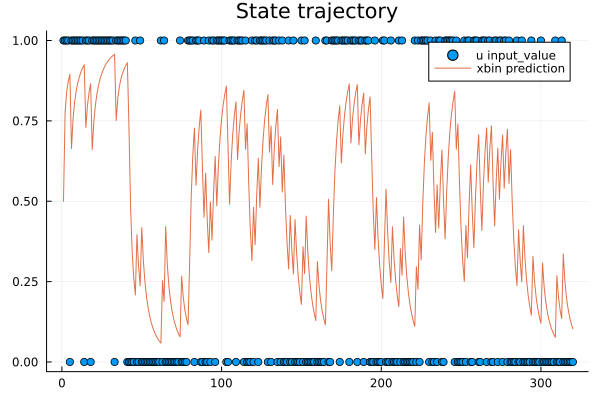

In [39]:
plot_trajectory(agent_binary_3_level, ("u", "input_value"))
plot_trajectory!(agent_binary_3_level, ("xbin", "prediction"))

&nbsp;
___

b) Try to recover the parameters you used to simulate beliefs and responses using the function `fit_model`, estimating $\zeta$, $\mu_3^{(0)}$, $\kappa_2$, and $\vartheta = \exp(\omega_3)$. You can use the following marginal priors on the free parameters:
\begin{align}
    p(\mu_3^{(0)}) &= \mathcal N(1,0.5) \\
    p(\kappa_2) &= \mathcal N(2.5,0.5) \\
    p(\omega_3) &= \mathcal N(-6,0.5) \\
    p(\zeta) &= \mathcal N(5,1) \\
\end{align}

Inspect the fit of the model and compare the posterior to the chosen prior. What do you observe? *(2 points)*


In [18]:
import ActionModels: single_agent_population_model, create_model

In [19]:
# 1) Extract the agent's history of actions:
actions = get_history(agent_binary_3_level, "action")  # returns a Vector of the action(s)

# skip the first missing element
actions = actions[2:end] 

# cast from Any to boolean
actions = Bool.(actions)

# 2) Bundle into a DataFrame:
df = DataFrame(u = u3[1:length(actions)], action = actions)

# 3) Specify priors for the parameters you want to estimate:
using Distributions
prior = Dict(
    # example: top-level initial mean
    ("xvol","initial_mean") => Normal(1.0, sqrt(0.5)),  
    # second-level drift
    (("xbin","xprob","coupling_strength")) => Normal(2.5, sqrt(0.5)), 
    # top-level log-vol
    ("xvol","volatility")   => Normal(-6.0, sqrt(0.5)),
    "action_noise"          => Normal(5, 1)
)

# 4) Build a “population model” with single-agent prior:
pop_model = single_agent_population_model(prior)

# 5) Create a full Turing model from your agent + data:
model = create_model(agent_binary_3_level, pop_model, df, input_cols = "u", action_cols = "action", grouping_cols = String[])

# 6) Fit the model:
using Turing
fit_results = fit_model(model; 
                        n_iterations=2000,
                        n_chains=1,
                        show_progress=true)

# # 7) Inspect results:
println(fit_results.chains)
describe(fit_results.chains)

Sampling (Chain 1 of 1)   0%|                           |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/vm/.julia/packages/Turing/QN7BL/src/mcmc/hmc.jl:212
Sampling (Chain 1 of 1)   0%|▏                          |  ETA: 0:24:35
Sampling (Chain 1 of 1)   1%|▎                          |  ETA: 0:12:44
Sampling (Chain 1 of 1)   2%|▍                          |  ETA: 0:08:43
Sampling (Chain 1 of 1)   2%|▌                          |  ETA: 0:06:45
Sampling (Chain 1 of 1)   2%|▋                          |  ETA: 0:05:32
Sampling (Chain 1 of 1)   3%|▊                          |  ETA: 0:04:44
Sampling (Chain 1 of 1)   4%|█                          |  ETA: 0:04:08
Sampling (Chain 1 of 1)   4%|█▏                         |  ETA: 0:03:42
Sampling (Chain 1 of 1)   4%|█▎                         |  ETA: 0:03:22
Sampling (Chain 1 of 1)   5%|█▍                         |  ETA: 0:03:06
Sampling (Chain 1 of 1)   6%|█▌                         |  ETA: 0:02:54
Sampling (Chain 

MCMC chain (2000×16×1 Array{Float64, 3}

)


2-element Vector{ChainDataFrame}:
 Summary Statistics (4 x 8)
 Quantiles (4 x 6)

In [20]:
fit_results.chains[1]

┌ Warning: number of draws after splitting must be >4 but is 0. ESS cannot be computed.
└ @ MCMCDiagnosticTools /Users/vm/.julia/packages/MCMCDiagnosticTools/hc08m/src/ess_rhat.jl:472
┌ Warning: number of draws after splitting must be >4 but is 0. ESS cannot be computed.
└ @ MCMCDiagnosticTools /Users/vm/.julia/packages/MCMCDiagnosticTools/hc08m/src/ess_rhat.jl:472
┌ Warning: number of draws after splitting must be >4 but is 0. ESS cannot be computed.
└ @ MCMCDiagnosticTools /Users/vm/.julia/packages/MCMCDiagnosticTools/hc08m/src/ess_rhat.jl:472
┌ Warning: number of draws after splitting must be >4 but is 0. ESS cannot be computed.
└ @ MCMCDiagnosticTools /Users/vm/.julia/packages/MCMCDiagnosticTools/hc08m/src/ess_rhat.jl:472


Chains MCMC chain (1×16×1 Array{Float64, 3}):

Iterations        = 1001:1:1001
Number of chains  = 1
Samples per chain = 1
Wall duration     = 48.57 seconds
Compute duration  = 48.57 seconds
parameters        = parameters[("xvol", "initial_mean")], parameters[("xbin", "xprob", "coupling_strength")], parameters[("xvol", "volatility")], parameters["action_noise"]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
                                          parameters      mean       std       ⋯
                                              Symbol   Float64   Float64   Flo ⋯

                parameters[("xvol", "initial_mean")]    0.4755       NaN       ⋯
  parameters[("xbin", "xprob", "coupling_strength")]    2.9590       NaN       ⋯
                  parameters[("xvol", "volatility")]   -6.4718       NaN       ⋯
      

## Original parameters for reference: 

\begin{equation}
  \begin{split}
  \mu_3^{(0)} = 1&, \quad \sigma_3^{(0)} = 1, \\
  \kappa_2 = 2.5&, \quad \omega_2 = -4, \\
  \vartheta = \exp(\omega_3) &= \exp(-6) = 0.0025,
  \end{split}
\end{equation}

$$ \zeta = 5. $$

## Comparison to model estimate

The parameter estimates show that $\kappa_2$ and $\zeta$ moved slightly above their original values (2.96 vs. 2.5 and 5.92 vs. 5, respectively), while $\omega_3$ shifted a bit below its original $-6$ to about $-6.47$. Notably, $\mu_3^{(0)}$ dropped from its prior mean of 1 to about 0.48 in the posterior, indicating that the data pushed this parameter away from the prior guess. Overall, these results suggest that while the model is broadly consistent with the prior means for $\kappa_2$, $\omega_3$, and $\zeta$, the data favors a smaller initial mean for $\mu_3$.

&nbsp;
___

c) Again, simulate beliefs and responses using your implementation of the 3-level HGF for binary inputs alongside the unit-square sigmoid action model, now with percetpual parameters:
\begin{equation}
  \begin{split}
  \mu_3^{(0)} = 2.5&, \quad \sigma_3^{(0)} = 6.25, \\
  \kappa_2 = 1&, \quad \omega_2 = -4, \\
  \vartheta = \exp(\omega_3) &= \exp(-4.1674) = 0.0155,
  \end{split}
\end{equation}
and action model parameter:
\begin{equation}
  \zeta = 5.
\end{equation}
Compare the belief trajectories with the ones you simulated in (a). What do you find? Can you explain this effect? *(2 points)*

In [32]:
function build_binary_3level_hgf_new_params()
    # Level-1 node: binary input
    node_u = BinaryInput("u")

    # Level-2 node: binary state
    node_xbin = BinaryState("xbin")

    # Level-3 node: continuous “probability” state
    #   ω₂ = -4   -> volatility = -4
    #   κ₂ = 2.5 -> drift = 2.5
    #   no explicit mention of the initial mean or precision in your problem for xprob, so just setting them to 0 and 1, respectively
    node_xprob = ContinuousState(
        name              = "xprob",
        volatility        = -4,    # log-vol = -4
        drift             = 0,
        autoconnection_strength = 1,
        initial_mean      = 0,
        initial_precision = 1,
    )

    # Level-4 node: continuous “volatility” state
    #   ω₃ = -6 -> volatility = -6
    #   μ₃^{(0)}=1, σ₃^{(0)}=1
    node_xvol = ContinuousState(
        name              = "xvol",
        volatility        = -4.1674,   # log-vol
        drift             = 0,   
        autoconnection_strength = 1,
        initial_mean      = 2.5,    # mu_3^{(0)}
        initial_precision = 6.25,    # sigma_3^{(0)}
    )

    # Define the edges connecting these nodes
    edges = Dict(
        ("u",     "xbin") => ObservationCoupling(),
        ("xbin",  "xprob") => ProbabilityCoupling(1), # κ₂ = 1
        ("xprob", "xvol")  => VolatilityCoupling(),
    )

    # Finally, create the HGF. We can choose EnhancedUpdate or ClassicUpdate.
    # If the problem doesn't specify, using EnhancedUpdate is a typical default for 3-level HGFs.
    hgf = init_hgf(
        nodes = [node_u, node_xbin, node_xprob, node_xvol],
        edges = edges,
        node_defaults = NodeDefaults(update_type = EnhancedUpdate()),
        save_history  = true,
    )

    return hgf
end

# build the 3-level HGF
hgf_2 = build_binary_3level_hgf_new_params()

config = Dict(
   "HGF" => hgf_2,                 # attach your HGF
   "action_noise" => 5,        # sets zeta=5
   "target_state" => ("xbin","prediction_mean")
)

agent_binary_3_level_2 = premade_agent("hgf_unit_square_sigmoid", config, verbose=true)

# 2) Run the agent on the input sequence
give_inputs!(agent_binary_3_level_2, u3)

┌ Warning: No update order specified. Using the order in which nodes were inputted
└ @ HierarchicalGaussianFiltering /Users/vm/.julia/packages/HierarchicalGaussianFiltering/4FcOu/src/create_hgf/init_hgf.jl:148


320-element Vector{Bool}:
 0
 1
 0
 1
 0
 0
 1
 0
 0
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 1
 1

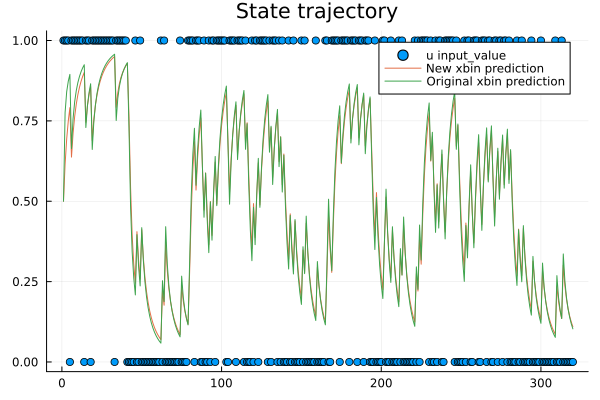

In [42]:
plot_trajectory(agent_binary_3_level_2, ("u", "input_value"))
plot_trajectory!(agent_binary_3_level_2, ("xbin", "prediction"), label="New xbin prediction")
plot_trajectory!(agent_binary_3_level, ("xbin", "prediction"), label="Original xbin prediction")

&nbsp;
___

d) By setting $\kappa_2$ to 1 and/or $\omega_2$ to 0, we can make these parameters seemingly disappear from the model. Try to write down a rule for how you would have to change the other parameters such that only $\mu_3$ is affected by this change, but the belief trajectories on the lower levels stay the same. What does that tell you? *(2 points)*

In [22]:
# insert your solution here ...

&nbsp;
___

e) We can actually get rid of the indeterminacy observed in (b) and (c) by including a readout of $\mu_3$ in our action model. This way, we can estimate all three, $\mu_3^{(0)}$, $\kappa_2$, and $\omega_2$, given observed responses. Try this by creating a new variant of the unit-square sigmoid action model, where $\mu_3$ determines the trial-by-trial decision temperature:

$$ p(y=1|\hat{\mu}_1, \mu_3) = \frac{\hat{\mu}_1^{\exp(-\mu_3)}}{\hat{\mu}_1^{\exp(-\mu_3)} + (1-\hat{\mu}_1)^{\exp(-\mu_3)}} $$

This means that agents will behave less deterministically the more volatile they believe the environment to be.

Repeat the exercise of (a) with the new action model. *(3 points)*

In [23]:
# insert your solution here ...